# DM - Data preparation [TASK 1.2]

Improve the quality of data and prepare it by extracting new features.

Library imports and initial settings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from utils import fetch_preprocessed_dataset, store_preprocessed_dataset
from utils import build_grid_plot
from utils.validators import check_int, MIN_DATE, MAX_DATE

import os
import sys
import logging as lg
import string

root = lg.getLogger()
root.setLevel(lg.INFO)

handler = lg.StreamHandler(sys.stdout)
handler.setLevel(lg.DEBUG)
formatter = lg.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
root.addHandler(handler)

nb_workers = int(os.cpu_count() / 2 + 1)

pandarallel.initialize(
    progress_bar=True,
    nb_workers=nb_workers,
)

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Fetching the dataset using our native python functions.

In [2]:
# Load the pickles
dataset = fetch_preprocessed_dataset(step_name="outlier_detection")
tweets = dataset['tweets.pickle']
users = dataset['users.pickle']

Before aggregating users and tweets dataset we should be clean user_id column from invalid values.

In [3]:
tweets = tweets[tweets['user_id'].parallel_map(check_int)]
tweets = tweets.astype({'user_id': 'int64'})

tweets.info()

/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10052836 entries, 0 to 13664695
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         int64         
 1   retweet_count   float64       
 2   reply_count     float64       
 3   favorite_count  float64       
 4   num_hashtags    float64       
 5   num_urls        float64       
 6   num_mentions    float64       
 7   created_at      datetime64[ns]
 8   text            string        
dtypes: datetime64[ns](1), float64(6), int64(1), string(1)
memory usage: 767.0 MB


## Data aggregation

Aggregation of `tweet_num`, so the number of tweets for each user.

In [4]:
column_name = 'tweets_num' 
tweets_grouped_by_users = tweets.groupby(['user_id']).size()

users = users.merge(tweets_grouped_by_users.to_frame(column_name), left_on='id', right_index=True)

users[column_name].describe()

count    11508.000000
mean       873.516597
std       1142.250366
min          1.000000
25%         59.750000
50%        121.000000
75%       1582.250000
max       3926.000000
Name: tweets_num, dtype: float64

Now is created another attribute called `tweets_2020_num` that represents the number of tweets of each users pulished in the year 2020.

In [5]:
column_name = 'tweets_2020_num'

def filter_datetime_2020(datetime):
    return MIN_DATE <= pd.Timestamp(datetime) < MAX_DATE

tweets_filtered_2020 = tweets[tweets['created_at'].parallel_map(filter_datetime_2020)]
tweets_grouped_2020 = tweets_filtered_2020.groupby(['user_id']).size()

users = users.merge(tweets_grouped_2020.to_frame(column_name), left_on='id', right_index=True)

users[column_name].describe()

/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


count    11508.000000
mean       865.112096
std       1128.659294
min          1.000000
25%         59.000000
50%        121.000000
75%       1567.000000
max       3467.000000
Name: tweets_2020_num, dtype: float64

Total number of likes per user added in column `likes_num`.

In [6]:
column_name = 'likes_num'
tweets_grouped_likes = tweets.groupby(['user_id'])['favorite_count'].sum()

users = users.merge(tweets_grouped_likes.to_frame(column_name), left_on='id', right_index=True)

users[column_name].describe()

count     11508.000000
mean       1234.076382
std       21344.947342
min           0.000000
25%           3.000000
50%           9.000000
75%         365.000000
max      868163.000000
Name: likes_num, dtype: float64

This new column `comments_num` represents for each user the total number of comments that he wrotes.

In [7]:
column_name = 'comments_num'
tweets_grouped_comments = tweets.groupby(['user_id'])['reply_count'].sum()

users = users.merge(tweets_grouped_comments.to_frame(column_name), left_on='id', right_index=True)

users[column_name].describe()

count    11508.000000
mean        56.104970
std        521.967526
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      10273.000000
Name: comments_num, dtype: float64

`ratio_likes_x_tweets` represent the number of likes for each tweet. 

In [8]:
column_name = 'ratio_likes_x_tweets'

users[column_name] = users['likes_num'] / users['tweets_num']
users[column_name].replace([np.nan, np.inf, -np.inf], 0, inplace=True)

users[column_name].describe()

count    11508.000000
mean         3.104821
std         33.290367
min          0.000000
25%          0.024768
50%          0.066146
75%          0.268293
max       1454.209380
Name: ratio_likes_x_tweets, dtype: float64

The entropy of user is accounted by `entropy` column computed on number of tweets done a user on total number of tweets.

In [9]:
column_name = 'entropy'
p_user_tweets = users['tweets_num'] / len(tweets)
users[column_name] = - (p_user_tweets * np.log2(p_user_tweets))

users[column_name].describe()

count    11508.000000
mean         0.001071
std          0.001324
min          0.000002
25%          0.000103
50%          0.000197
75%          0.001988
max          0.004422
Name: entropy, dtype: float64

Here is aggregated the mean of texts length for each user by the new column `texts_mean_length`.

In [10]:
column_name = 'texts_mean_length'
tweets[column_name] = tweets['text'].parallel_map(lambda t: len(t))
tweets_grouped_text_length = tweets.groupby(['user_id'])[column_name].mean()

users = users.merge(tweets_grouped_text_length.to_frame(column_name), left_on='id', right_index=True)

users[column_name].describe()

/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


count    11508.000000
mean        70.273139
std         16.636644
min          3.000000
25%         61.516377
50%         67.494258
75%         79.642466
max        245.000000
Name: texts_mean_length, dtype: float64

`texts_special_chars_length` represents the mean number of special character inside texts for each user.

In [11]:
column_name = 'texts_special_chars_length'
VALID_CHARACTERS = string.ascii_letters + string.digits + " " + "\n"

def count_special_chars(text):
    count = 0
    for ch in text:
        count += 0 if ch in VALID_CHARACTERS else 1
    return count

tweets[column_name] = tweets['text'].parallel_map(count_special_chars)
tweets_grouped_text_sc_length = tweets.groupby(['user_id'])[column_name].mean()

users = users.merge(tweets_grouped_text_sc_length.to_frame(column_name), left_on='id', right_index=True)

users[column_name].describe()

/usr/local/lib/python3.10/dist-packages/pandarallel/data_types/series.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


count    11508.000000
mean         7.324552
std         12.005750
min          0.000000
25%          3.829188
50%          4.766878
75%          6.489471
max        215.000000
Name: texts_special_chars_length, dtype: float64

Here we aggregate the mean of time between two contiguous publications for each user.

In [12]:
column_name = 'mean_pub_range'

# sortig by publication datetime
mean_pub_range = tweets.sort_values(by=['created_at'], ascending=True)
# group by user_id
mean_pub_range = mean_pub_range.groupby('user_id')['created_at']
# apply a mapping function that average 'created_at' attribute for each user
mean_pub_range = mean_pub_range.apply(lambda x: 0 if len(x) <= 1 else x.diff().mean().total_seconds())
    
users = users.merge(mean_pub_range.to_frame(column_name), left_on='id', right_index=True)

users[column_name].describe()

count    1.150800e+04
mean     5.773337e+05
std      7.173285e+06
min      0.000000e+00
25%      1.588349e+04
50%      9.728591e+04
75%      3.178114e+05
max      6.319793e+08
Name: mean_pub_range, dtype: float64

Now we want to copute an index that express the similarity among tweets of the same user according TF-IDF and cosine similarity techniques. At the beginning we create a dataframe with all the texts not empty.

In [13]:
tweets_text_filled = tweets[tweets['text'] != ''][['user_id', 'text']]

tweets_text_filled

,user_id,text
0,327746321,"If man is a little lower than angels, then ang..."
1,333722906,"""@BestWSHHVids: how do you say these words wit..."
2,2379755827,@LOLatComedy awsome
3,466226882,Stephen Hawkins: i buchi neri non esistono se ...
4,1355537995,RT @tibbs_montris: So ready for Wednesday!
...,...,...
13664687,2272611686,C'Ã¨ un momento in cui sentire ed ascoltare si...
13664689,8657052,@_victoriamm twoot.
13664691,587491046,"@warriors Congrats, maybe I'll be able to get ..."
13664694,127895572,Shooting crew of porn movies. #TheWorstJobToHave


Now we fit the `TfidfVectorizer` object on the entire dataset of tweets texts.

In [14]:
vectorizer = TfidfVectorizer()
docs = vectorizer.fit_transform(tweets_text_filled['text'])

docs.shape

(10014236, 3984720)

Then we group by users id and apply the cosine similarity of their texts transformed in list of tf-idf of tokens that are inside `docs` matrix.

In [15]:
# definition of function to compute different texts cosine similarity
def texts_similarity(x):
    if len(x) <= 1:
        # outlier placeholder used when we can't compute cosine similarity because we have less then one element
        return -1
    else:
        # we compute the tweets position inside tweets_text_filled to retrieve from docs the corresponding tf-idf encoding
        positions = np.argwhere(tweets_text_filled.index.isin(x.index)).flatten()
        similarity_matrix = cosine_similarity(docs[positions])
        return similarity_matrix[np.triu_indices(similarity_matrix.shape[0], 1)].mean()

column_name = 'mean_texts_similarity'
mean_texts_similarity = tweets_text_filled.groupby('user_id')
mean_texts_similarity = mean_texts_similarity.parallel_apply(texts_similarity)
users = users.merge(mean_texts_similarity.to_frame(column_name), left_on='id', right_index=True)

users[column_name].describe()

count    11508.000000
mean         0.009903
std          0.108406
min         -1.000000
25%          0.009897
50%          0.013568
75%          0.019440
max          1.000000
Name: mean_texts_similarity, dtype: float64

## Data description

Description of users columns statistichs.

In [16]:
users.describe()

,id,statuses_count,tweets_num,tweets_2020_num,likes_num,comments_num,ratio_likes_x_tweets,entropy,texts_mean_length,texts_special_chars_length,mean_pub_range,mean_texts_similarity
count,1.150800e+04,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,1.150800e+04,11508.000000
mean,1.274517e+09,5681.686566,873.516597,865.112096,1234.076382,56.104970,3.104821,0.001071,70.273139,7.324552,5.773337e+05,0.009903
std,9.354135e+08,18769.594489,1142.250366,1128.659294,21344.947342,521.967526,33.290367,0.001324,16.636644,12.005750,7.173285e+06,0.108406
min,6.780330e+05,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000002,3.000000,0.000000,0.000000e+00,-1.000000
25%,4.663594e+08,42.000000,59.750000,59.000000,3.000000,0.000000,0.024768,0.000103,61.516377,3.829188,1.588349e+04,0.009897
50%,1.128643e+09,68.000000,121.000000,121.000000,9.000000,0.000000,0.066146,0.000197,67.494258,4.766878,9.728591e+04,0.013568
75%,2.357148e+09,2520.250000,1582.250000,1567.000000,365.000000,0.000000,0.268293,0.001988,79.642466,6.489471,3.178114e+05,0.019440
max,3.164942e+09,399555.000000,3926.000000,3467.000000,868163.000000,10273.000000,1454.209380,0.004422,245.000000,215.000000,6.319793e+08,1.000000


Following line of code shows first users dataset rows.

In [17]:
users.head()

,id,name,lang,bot,created_at,statuses_count,tweets_num,tweets_2020_num,likes_num,comments_num,ratio_likes_x_tweets,entropy,texts_mean_length,texts_special_chars_length,mean_pub_range,mean_texts_similarity
0,2353593986,Lamonica Raborn,en,True,2019-02-22 18:00:42,76,118,118,5.0,0.0,0.042373,0.000192,63.423729,4.076271,91920.076923,0.010965
1,2358850842,Lourie Botton,en,False,2019-02-26 03:02:32,54,104,104,6.0,0.0,0.057692,0.000171,69.961538,3.663462,104308.291262,0.015519
2,137959629,Dadan Syarifudin,en,True,2015-04-30 07:09:56,3,3,3,0.0,0.0,0.000000,0.000006,17.333333,4.333333,32322.000000,0.333333
3,466124818,Carletto Focia,it,True,2017-01-18 02:49:18,50,1253,1253,240.0,0.0,0.191540,0.001617,89.628891,5.734238,62427.395367,0.021998
4,2571493866,MBK Ebook,en,False,2019-06-18 19:30:21,7085,3217,3217,207.0,0.0,0.064346,0.003715,74.583152,3.718993,3238.683457,0.014382


## Distribution analysis

Users histograms of new values to show their distribution.

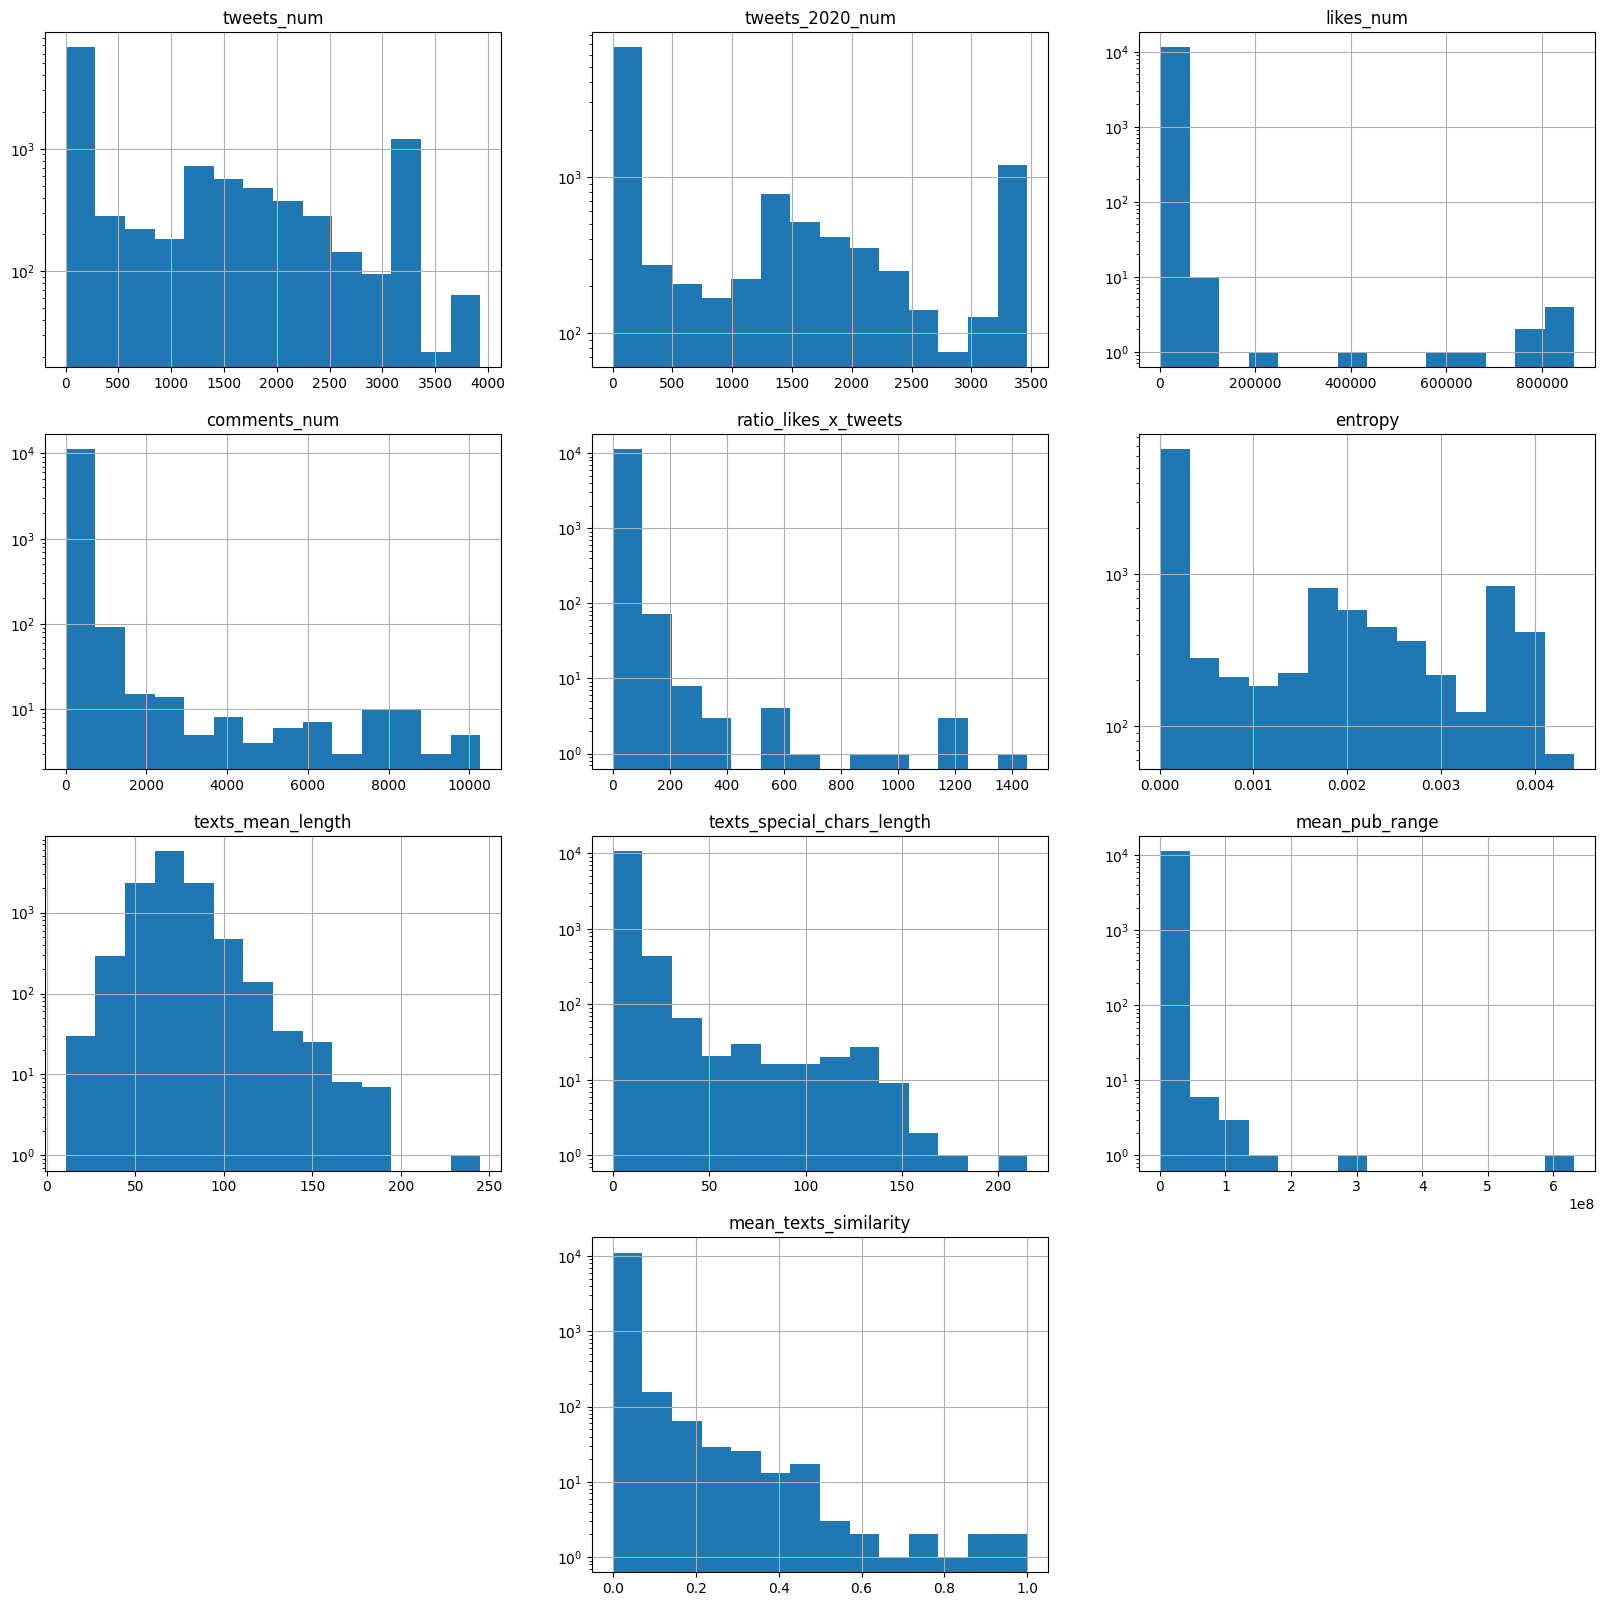

In [18]:
users_to_plot = users[users['mean_texts_similarity'] >= 0]

users_num_cols = ['tweets_num', 'tweets_2020_num', 'likes_num', 'comments_num', 'ratio_likes_x_tweets', 'entropy', 'texts_mean_length', 'texts_special_chars_length', 'mean_pub_range', 'mean_texts_similarity']

configs = [
    {
        'type': 'hist',
        'column': users_to_plot[col],
        'title': col,
        'yscale': 'log',
    } for col in users_num_cols
]

build_grid_plot(configs=configs)

### Outliers detection

Box-plots that shows new aggregated attributes outliers.

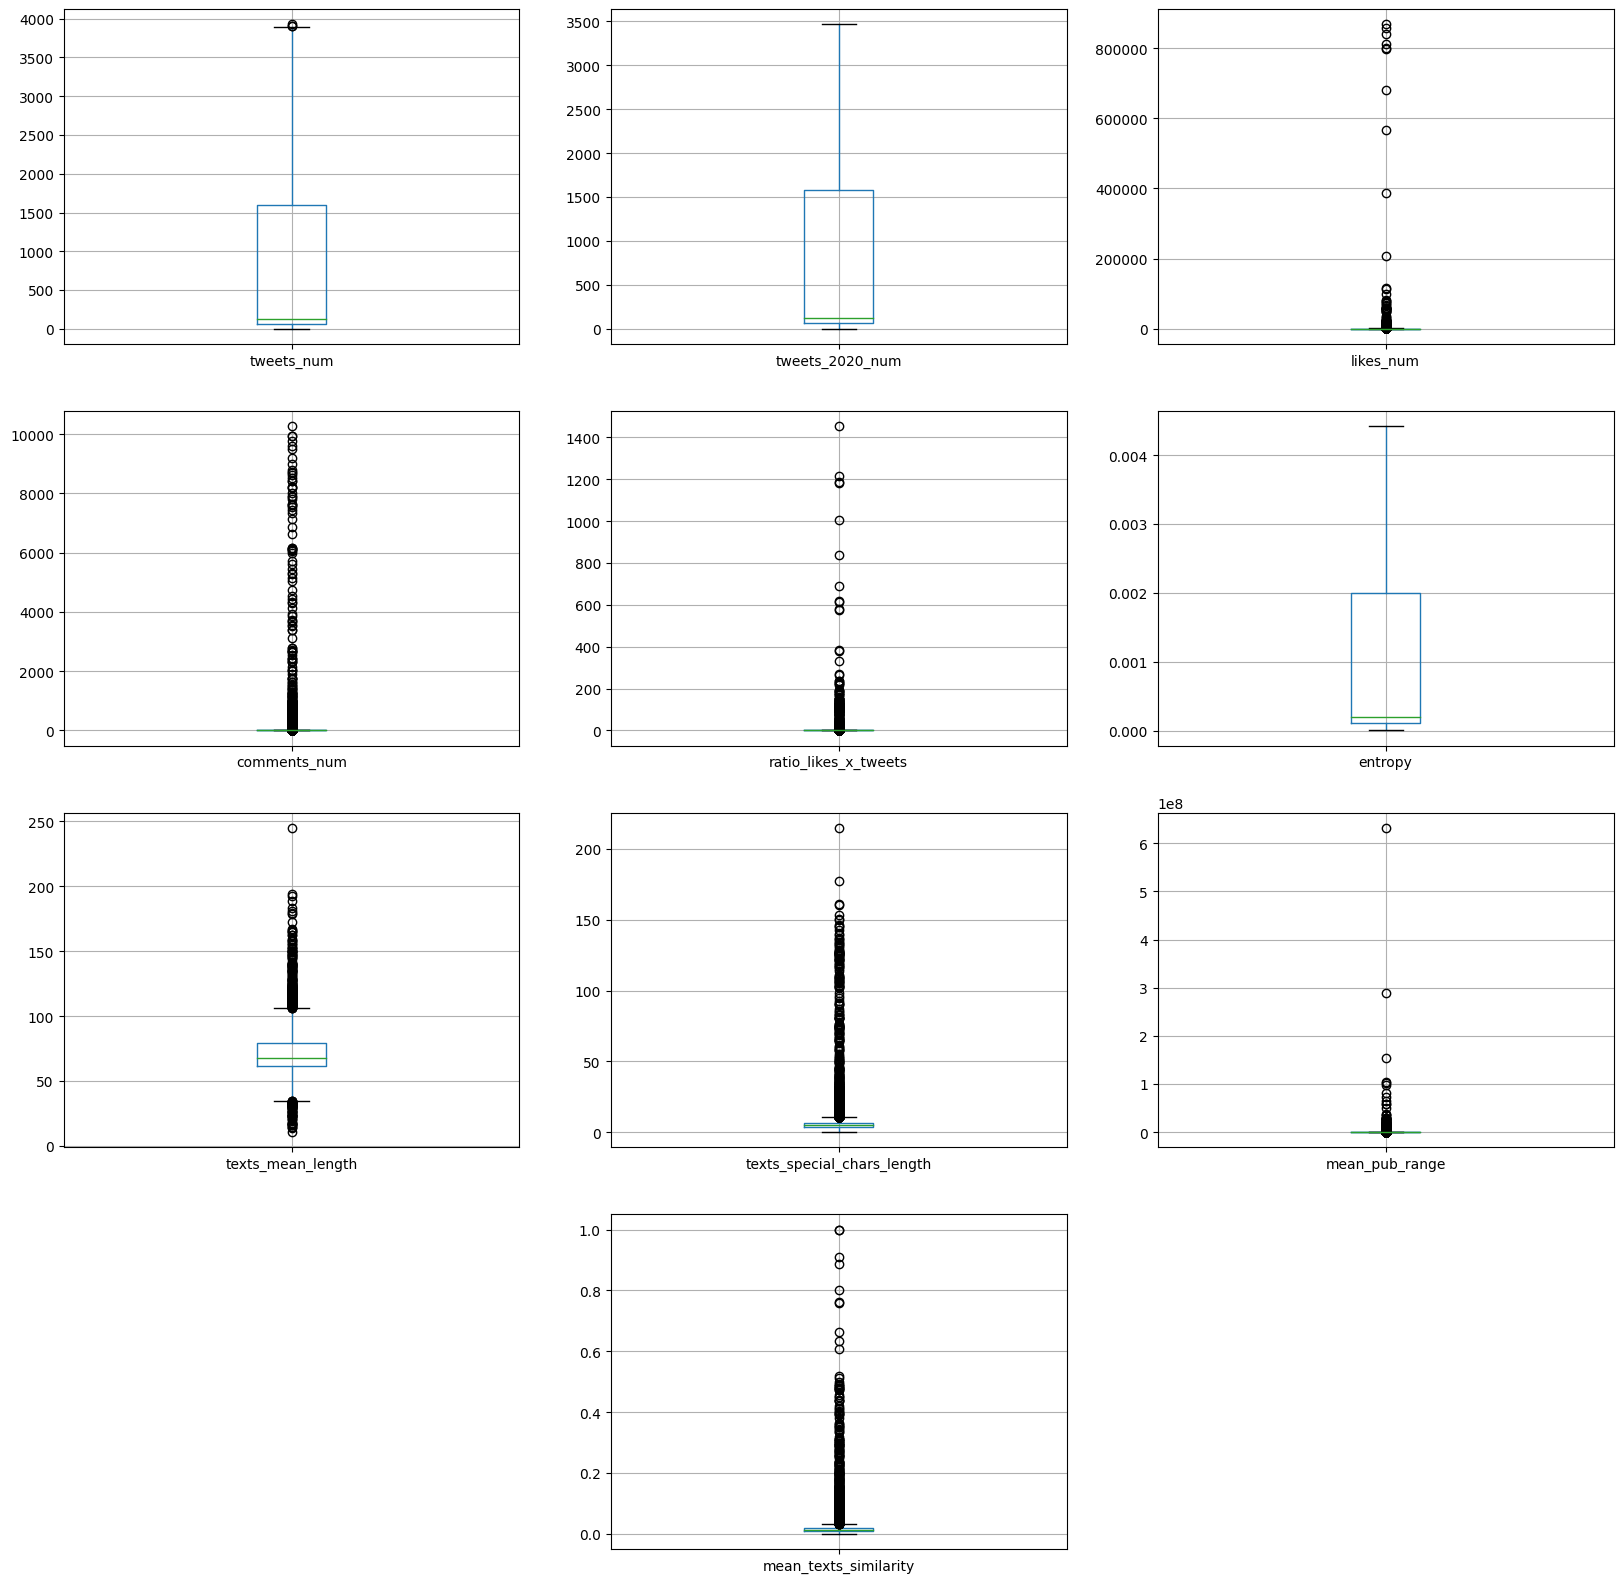

In [19]:
def boxplot_tweets_newfeatures_show():
    configs = [
        {
            'type': 'boxplot',
            'df': users_to_plot,
            'columns': [col]
        } for col in users_num_cols
    ]

    build_grid_plot(configs=configs)

boxplot_tweets_newfeatures_show()

Here are printed the percentage of outliers over and below the two box-plot whiskers for each new numerical attribute of users dataset.

In [20]:
for col in users_num_cols:
    Q1 = np.quantile(users_to_plot[col], 0.25)
    Q3 = np.quantile(users_to_plot[col], 0.75)
    IQR = Q3 - Q1
    superior_whisker = Q3 + 1.5 * IQR
    inferior_whisker = min(superior_whisker, max(users_to_plot[col]))
    outliers_perc_sup = len(users_to_plot[users_to_plot[col] > superior_whisker]) / len(users_to_plot) * 100
    inferior_whisker = Q1 - 1.5 * IQR
    inferior_whisker = max(inferior_whisker, min(users_to_plot[col]))
    outliers_perc_inf = len(users_to_plot[users_to_plot[col] < inferior_whisker]) / len(users_to_plot) * 100
    outliers_perc = outliers_perc_sup + outliers_perc_inf
    lg.info(f'{outliers_perc} % of column {col} are over superior whisker ({superior_whisker}) and below inferior one ({inferior_whisker})')

2022-11-07 03:45:54,544 - root - INFO - 0.026325026325026327 % of column tweets_num are over superior whisker (3899.0) and below inferior one (2)
2022-11-07 03:45:54,550 - root - INFO - 0.0 % of column tweets_2020_num are over superior whisker (3859.625) and below inferior one (2)
2022-11-07 03:45:54,555 - root - INFO - 14.136539136539136 % of column likes_num are over superior whisker (925.5) and below inferior one (0.0)
2022-11-07 03:45:54,559 - root - INFO - 18.813618813618813 % of column comments_num are over superior whisker (0.0) and below inferior one (0.0)
2022-11-07 03:45:54,563 - root - INFO - 13.697788697788699 % of column ratio_likes_x_tweets are over superior whisker (0.6403031123327225) and below inferior one (0.0)
2022-11-07 03:45:54,568 - root - INFO - 0.0 % of column entropy are over superior whisker (0.004849977593305844) and below inferior one (4.428819732249687e-06)
2022-11-07 03:45:54,572 - root - INFO - 3.264303264303264 % of column texts_mean_length are over supe

### Correlation

Correlation matrix according old and new numerical values of users dataset.

In [21]:
corr = users_to_plot.corr(method='pearson', numeric_only=True).loc[users_num_cols, users_num_cols]
corr.style.background_gradient(cmap='coolwarm')

,tweets_num,tweets_2020_num,likes_num,comments_num,ratio_likes_x_tweets,entropy,texts_mean_length,texts_special_chars_length,mean_pub_range,mean_texts_similarity
tweets_num,1.000000,0.998504,0.033096,0.112468,-0.039560,0.999026,0.162692,-0.079789,-0.041937,0.006609
tweets_2020_num,0.998504,1.000000,0.033497,0.114635,-0.039424,0.997833,0.162578,-0.080263,-0.044757,0.007305
likes_num,0.033096,0.033497,1.000000,0.023905,0.797530,0.035199,0.081995,0.015129,-0.003862,0.002403
comments_num,0.112468,0.114635,0.023905,1.000000,0.025278,0.112457,0.035930,0.022097,-0.007083,0.019073
ratio_likes_x_tweets,-0.039560,-0.039424,0.797530,0.025278,1.000000,-0.039570,0.086710,0.067915,-0.002181,0.014834
entropy,0.999026,0.997833,0.035199,0.112457,-0.039570,1.000000,0.171274,-0.081822,-0.043848,0.006866
texts_mean_length,0.162692,0.162578,0.081995,0.035930,0.086710,0.171274,1.000000,0.481231,-0.016238,0.298438
texts_special_chars_length,-0.079789,-0.080263,0.015129,0.022097,0.067915,-0.081822,0.481231,1.000000,0.008123,0.516287
mean_pub_range,-0.041937,-0.044757,-0.003862,-0.007083,-0.002181,-0.043848,-0.016238,0.008123,1.000000,0.074480
mean_texts_similarity,0.006609,0.007305,0.002403,0.019073,0.014834,0.006866,0.298438,0.516287,0.074480,1.000000


In [22]:
# save users_total as pickle
store_preprocessed_dataset(step_name="users_total", file_name="users.pickle", df=users)